In [100]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import torch.nn.functional as F
import os
from tqdm import tqdm

class SingleLayerNN(nn.Module):
    def __init__(self):
        super(SingleLayerNN, self).__init__()
        self.fc = nn.Linear(784, 256) 
        self.fc1 = nn.Linear(256, 128)
        self.fc2 = nn.Linear(128, 64)
        self.out = nn.Linear(64, 10)

    def forward(self, x):
        x = torch.relu(self.fc(x)) 
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.out(x)  
        return x

model = SingleLayerNN()


criterion = nn.MSELoss() 
optimizer = optim.Adam(model.parameters(), lr=0.01)  


In [101]:
#torch.manual_seed(7)

In [102]:
train_dataset = MNIST(os.getcwd(), train=True, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_train = train_dataset.data / 255.0
y_train = F.one_hot(train_dataset.targets, num_classes=10)
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
x_train = x_train.view(-1, 784)
dtrain = torch.utils.data.TensorDataset(x_train, y_train)
trainloader = DataLoader(dtrain, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_62236/112231088.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_train = torch.tensor(x_train, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_62236/112231088.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train = torch.tensor(y_train, dtype=torch.float32)


In [103]:
testDataset = MNIST(os.getcwd(), train=False, download=True, transform=[transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
x_test = testDataset.data / 255.0
y_test = F.one_hot(testDataset.targets, num_classes=10)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)
x_test = x_test.view(-1, 784)
dtest = torch.utils.data.TensorDataset(x_test, y_test)
testloader = DataLoader(dtest, batch_size=256, shuffle=True)

/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_62236/3473755828.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_test = torch.tensor(x_test, dtype=torch.float32)
/var/folders/d1/pxwd2rcj41j7b2lhnz909xn80000gn/T/ipykernel_62236/3473755828.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_test = torch.tensor(y_test, dtype=torch.float32)


In [104]:
def neuronalNeuralBalance(inl, oul):

    ninc = torch.zeros_like(inl.weight)
    noul = torch.zeros_like(oul.weight)

    for i in range(inl.weight.data.shape[0]):
        inc = np.sqrt(torch.sum(torch.square(inl.weight.data[i])).item())
        outg = np.sqrt(torch.sum(torch.square(oul.weight.data[:,i])).item())

        # outg = outg / float(len(oul.weight.data[:,i]))
        # inc = inc / float(len(inl.weight.data[i]))

        opt = np.sqrt(outg/inc)

        ninc[i] = inl.weight.data[i]*opt
        noul[:, i] = oul.weight.data[:,i]/opt

    inl.weight.data = ninc
    oul.weight.data = noul


In [105]:
model = model
lay = []
for n, i in model.named_children():
    print(type(i).__name__)
    if type(i).__name__ == "Linear":
        lay.append((n, i))

acc = []

num_epochs = 100  
for epoch in range(num_epochs):
    ttot = 0
    tcorr = 0
    for b in tqdm(trainloader):
        xt, y = b[0], b[1]
        optimizer.zero_grad() 
        outputs = model(xt)  
        loss = criterion(outputs, y) 
        
        loss.backward() 
        optimizer.step() 
    
        _, y = torch.max(y.data, 1)
        _, pred = torch.max(outputs.data, 1)
        ttot += y.shape[0]
        tcorr += (pred == y).sum().item()
    
    # for i in range(len(lay)):
    #     if i > 0 and i <= len(lay)-1:
    #         di = neuronalNeuralBalance(lay[i-1][1], lay[i][1])

    print(f'Epoch {epoch}/{num_epochs}, Loss: {loss.item()}, train dataset accuracy: {100*tcorr/ttot}')
        
    tot = 0
    corr = 0

    with torch.no_grad():
        for i in testloader:
            xt, y = i[0], i[1]
            outputs = model(xt)  
            _, y = torch.max(y.data, 1)
            _, pred = torch.max(outputs.data, 1)
            tot += y.shape[0]
            corr += (pred == y).sum().item()
    print(f'test dataset accuracy: {100*corr/tot}%')
    acc.append(corr/tot)


Linear
Linear
Linear
Linear


100%|██████████| 235/235 [00:00<00:00, 236.52it/s]


Epoch 0/100, Loss: 0.008566333912312984, train dataset accuracy: 88.91
test dataset accuracy: 95.09%


100%|██████████| 235/235 [00:00<00:00, 252.32it/s]


Epoch 1/100, Loss: 0.008173114620149136, train dataset accuracy: 95.80333333333333
test dataset accuracy: 95.51%


100%|██████████| 235/235 [00:00<00:00, 269.28it/s]


Epoch 2/100, Loss: 0.0046248179860413074, train dataset accuracy: 96.49166666666666
test dataset accuracy: 96.04%


100%|██████████| 235/235 [00:00<00:00, 265.93it/s]


Epoch 3/100, Loss: 0.009694120846688747, train dataset accuracy: 96.8
test dataset accuracy: 96.19%


100%|██████████| 235/235 [00:00<00:00, 271.55it/s]


Epoch 4/100, Loss: 0.002645989414304495, train dataset accuracy: 97.155
test dataset accuracy: 96.41%


100%|██████████| 235/235 [00:00<00:00, 240.45it/s]


Epoch 5/100, Loss: 0.012109259143471718, train dataset accuracy: 97.46666666666667
test dataset accuracy: 96.43%


100%|██████████| 235/235 [00:00<00:00, 266.44it/s]


Epoch 6/100, Loss: 0.0012131263501942158, train dataset accuracy: 97.51833333333333
test dataset accuracy: 96.48%


100%|██████████| 235/235 [00:00<00:00, 273.12it/s]


Epoch 7/100, Loss: 0.004205134231597185, train dataset accuracy: 97.73666666666666
test dataset accuracy: 96.45%


100%|██████████| 235/235 [00:00<00:00, 250.20it/s]


Epoch 8/100, Loss: 0.0029672866221517324, train dataset accuracy: 97.86166666666666
test dataset accuracy: 96.58%


100%|██████████| 235/235 [00:00<00:00, 265.40it/s]


Epoch 9/100, Loss: 0.0019346853950992227, train dataset accuracy: 97.985
test dataset accuracy: 96.88%


100%|██████████| 235/235 [00:00<00:00, 266.41it/s]


Epoch 10/100, Loss: 0.006168701685965061, train dataset accuracy: 98.08666666666667
test dataset accuracy: 96.4%


100%|██████████| 235/235 [00:00<00:00, 271.37it/s]


Epoch 11/100, Loss: 0.0007406898075714707, train dataset accuracy: 98.08333333333333
test dataset accuracy: 96.56%


100%|██████████| 235/235 [00:00<00:00, 276.89it/s]


Epoch 12/100, Loss: 0.0013824341585859656, train dataset accuracy: 98.21166666666667
test dataset accuracy: 96.78%


100%|██████████| 235/235 [00:00<00:00, 260.10it/s]


Epoch 13/100, Loss: 0.001802552491426468, train dataset accuracy: 98.21833333333333
test dataset accuracy: 96.84%


100%|██████████| 235/235 [00:00<00:00, 262.88it/s]


Epoch 14/100, Loss: 0.00045554578537121415, train dataset accuracy: 98.35
test dataset accuracy: 96.87%


100%|██████████| 235/235 [00:00<00:00, 239.86it/s]


Epoch 15/100, Loss: 0.0025468701496720314, train dataset accuracy: 98.42833333333333
test dataset accuracy: 96.8%


100%|██████████| 235/235 [00:00<00:00, 268.56it/s]


Epoch 16/100, Loss: 0.0026819095946848392, train dataset accuracy: 98.48833333333333
test dataset accuracy: 96.51%


100%|██████████| 235/235 [00:00<00:00, 251.19it/s]


Epoch 17/100, Loss: 0.0035240359138697386, train dataset accuracy: 98.41833333333334
test dataset accuracy: 96.52%


100%|██████████| 235/235 [00:00<00:00, 267.29it/s]


Epoch 18/100, Loss: 0.004139474593102932, train dataset accuracy: 98.45833333333333
test dataset accuracy: 96.81%


100%|██████████| 235/235 [00:00<00:00, 261.66it/s]


Epoch 19/100, Loss: 0.004236423876136541, train dataset accuracy: 98.545
test dataset accuracy: 96.43%


100%|██████████| 235/235 [00:00<00:00, 273.11it/s]


Epoch 20/100, Loss: 0.0021105739288032055, train dataset accuracy: 98.535
test dataset accuracy: 96.94%


100%|██████████| 235/235 [00:00<00:00, 252.40it/s]


Epoch 21/100, Loss: 0.0022454620338976383, train dataset accuracy: 98.605
test dataset accuracy: 96.59%


100%|██████████| 235/235 [00:00<00:00, 267.36it/s]


Epoch 22/100, Loss: 0.0016127004055306315, train dataset accuracy: 98.605
test dataset accuracy: 96.62%


100%|██████████| 235/235 [00:00<00:00, 267.18it/s]


Epoch 23/100, Loss: 0.003037612419575453, train dataset accuracy: 98.59166666666667
test dataset accuracy: 96.36%


100%|██████████| 235/235 [00:00<00:00, 260.37it/s]


Epoch 24/100, Loss: 0.0015811080811545253, train dataset accuracy: 98.73
test dataset accuracy: 96.91%


100%|██████████| 235/235 [00:00<00:00, 251.48it/s]


Epoch 25/100, Loss: 0.002828691154718399, train dataset accuracy: 98.75333333333333
test dataset accuracy: 96.93%


100%|██████████| 235/235 [00:00<00:00, 272.43it/s]


Epoch 26/100, Loss: 0.003434533718973398, train dataset accuracy: 98.7
test dataset accuracy: 96.84%


100%|██████████| 235/235 [00:00<00:00, 271.62it/s]


Epoch 27/100, Loss: 0.0032299773301929235, train dataset accuracy: 98.66166666666666
test dataset accuracy: 96.9%


100%|██████████| 235/235 [00:00<00:00, 279.80it/s]


Epoch 28/100, Loss: 0.0008947319001890719, train dataset accuracy: 98.76333333333334
test dataset accuracy: 96.75%


100%|██████████| 235/235 [00:00<00:00, 241.12it/s]


Epoch 29/100, Loss: 0.001414711237885058, train dataset accuracy: 98.80666666666667
test dataset accuracy: 96.69%


100%|██████████| 235/235 [00:00<00:00, 267.23it/s]


Epoch 30/100, Loss: 0.0026623497251421213, train dataset accuracy: 98.86833333333334
test dataset accuracy: 96.79%


100%|██████████| 235/235 [00:00<00:00, 269.72it/s]


Epoch 31/100, Loss: 0.0017383962403982878, train dataset accuracy: 98.77166666666666
test dataset accuracy: 96.74%


100%|██████████| 235/235 [00:00<00:00, 272.73it/s]


Epoch 32/100, Loss: 0.001549151143990457, train dataset accuracy: 98.78666666666666
test dataset accuracy: 96.51%


100%|██████████| 235/235 [00:00<00:00, 254.48it/s]


Epoch 33/100, Loss: 0.0032352455891668797, train dataset accuracy: 98.85166666666667
test dataset accuracy: 96.9%


100%|██████████| 235/235 [00:00<00:00, 258.42it/s]


Epoch 34/100, Loss: 0.0021171176340430975, train dataset accuracy: 98.95666666666666
test dataset accuracy: 96.62%


100%|██████████| 235/235 [00:00<00:00, 277.19it/s]


Epoch 35/100, Loss: 0.0020890093874186277, train dataset accuracy: 98.93666666666667
test dataset accuracy: 96.58%


100%|██████████| 235/235 [00:00<00:00, 270.98it/s]


Epoch 36/100, Loss: 0.002097619930282235, train dataset accuracy: 98.93833333333333
test dataset accuracy: 96.78%


100%|██████████| 235/235 [00:00<00:00, 268.19it/s]


Epoch 37/100, Loss: 0.0004612258344423026, train dataset accuracy: 98.98166666666667
test dataset accuracy: 96.66%


100%|██████████| 235/235 [00:00<00:00, 270.91it/s]


Epoch 38/100, Loss: 0.0033925508614629507, train dataset accuracy: 98.935
test dataset accuracy: 96.62%


100%|██████████| 235/235 [00:00<00:00, 270.54it/s]


Epoch 39/100, Loss: 0.0019089807756245136, train dataset accuracy: 98.95833333333333
test dataset accuracy: 96.77%


100%|██████████| 235/235 [00:00<00:00, 268.96it/s]


Epoch 40/100, Loss: 0.0026189670898020267, train dataset accuracy: 98.955
test dataset accuracy: 96.73%


100%|██████████| 235/235 [00:00<00:00, 267.97it/s]


Epoch 41/100, Loss: 0.0026744792703539133, train dataset accuracy: 98.95333333333333
test dataset accuracy: 96.89%


100%|██████████| 235/235 [00:00<00:00, 271.19it/s]


Epoch 42/100, Loss: 0.0033101611770689487, train dataset accuracy: 98.99666666666667
test dataset accuracy: 96.88%


100%|██████████| 235/235 [00:00<00:00, 267.45it/s]


Epoch 43/100, Loss: 0.002484456403180957, train dataset accuracy: 99.04833333333333
test dataset accuracy: 96.69%


100%|██████████| 235/235 [00:00<00:00, 260.91it/s]


Epoch 44/100, Loss: 0.0025098836049437523, train dataset accuracy: 99.075
test dataset accuracy: 96.63%


100%|██████████| 235/235 [00:00<00:00, 269.27it/s]


Epoch 45/100, Loss: 0.00031187283457256854, train dataset accuracy: 99.07666666666667
test dataset accuracy: 96.8%


100%|██████████| 235/235 [00:00<00:00, 275.48it/s]


Epoch 46/100, Loss: 0.0041274321265518665, train dataset accuracy: 99.11333333333333
test dataset accuracy: 96.86%


100%|██████████| 235/235 [00:00<00:00, 271.06it/s]


Epoch 47/100, Loss: 0.0004155132919549942, train dataset accuracy: 98.98166666666667
test dataset accuracy: 96.8%


100%|██████████| 235/235 [00:00<00:00, 269.16it/s]


Epoch 48/100, Loss: 0.001155320554971695, train dataset accuracy: 99.15
test dataset accuracy: 96.94%


100%|██████████| 235/235 [00:00<00:00, 270.61it/s]


Epoch 49/100, Loss: 0.00032577317324467003, train dataset accuracy: 99.06166666666667
test dataset accuracy: 96.56%


100%|██████████| 235/235 [00:00<00:00, 258.29it/s]


Epoch 50/100, Loss: 0.002262332011014223, train dataset accuracy: 98.98833333333333
test dataset accuracy: 96.74%


100%|██████████| 235/235 [00:00<00:00, 276.15it/s]


Epoch 51/100, Loss: 0.0038583811838179827, train dataset accuracy: 98.92333333333333
test dataset accuracy: 96.64%


100%|██████████| 235/235 [00:00<00:00, 270.87it/s]


Epoch 52/100, Loss: 0.0030566256027668715, train dataset accuracy: 99.03333333333333
test dataset accuracy: 96.47%


100%|██████████| 235/235 [00:00<00:00, 272.50it/s]


Epoch 53/100, Loss: 0.002725853119045496, train dataset accuracy: 99.13666666666667
test dataset accuracy: 96.68%


100%|██████████| 235/235 [00:00<00:00, 261.87it/s]


Epoch 54/100, Loss: 0.0013339378638193011, train dataset accuracy: 99.215
test dataset accuracy: 96.86%


100%|██████████| 235/235 [00:00<00:00, 266.59it/s]


Epoch 55/100, Loss: 0.0012517651775851846, train dataset accuracy: 99.07833333333333
test dataset accuracy: 96.65%


100%|██████████| 235/235 [00:00<00:00, 275.46it/s]


Epoch 56/100, Loss: 0.00223112222738564, train dataset accuracy: 99.19666666666667
test dataset accuracy: 96.72%


100%|██████████| 235/235 [00:00<00:00, 277.38it/s]


Epoch 57/100, Loss: 0.002511363010853529, train dataset accuracy: 99.06
test dataset accuracy: 96.85%


100%|██████████| 235/235 [00:00<00:00, 249.74it/s]


Epoch 58/100, Loss: 0.0005648202495649457, train dataset accuracy: 99.07666666666667
test dataset accuracy: 96.83%


100%|██████████| 235/235 [00:00<00:00, 271.49it/s]


Epoch 59/100, Loss: 0.0015048611676320434, train dataset accuracy: 99.15333333333334
test dataset accuracy: 96.8%


100%|██████████| 235/235 [00:00<00:00, 280.84it/s]


Epoch 60/100, Loss: 0.0006894839461892843, train dataset accuracy: 99.17166666666667
test dataset accuracy: 96.59%


100%|██████████| 235/235 [00:00<00:00, 272.26it/s]


Epoch 61/100, Loss: 0.00020050350576639175, train dataset accuracy: 99.16833333333334
test dataset accuracy: 96.77%


100%|██████████| 235/235 [00:00<00:00, 277.62it/s]


Epoch 62/100, Loss: 0.0002537621185183525, train dataset accuracy: 99.215
test dataset accuracy: 96.8%


100%|██████████| 235/235 [00:00<00:00, 276.79it/s]


Epoch 63/100, Loss: 0.0026920114178210497, train dataset accuracy: 99.225
test dataset accuracy: 96.68%


100%|██████████| 235/235 [00:00<00:00, 268.92it/s]


Epoch 64/100, Loss: 0.0003197283367626369, train dataset accuracy: 99.115
test dataset accuracy: 96.88%


100%|██████████| 235/235 [00:00<00:00, 267.95it/s]


Epoch 65/100, Loss: 0.002881365129724145, train dataset accuracy: 99.245
test dataset accuracy: 96.94%


100%|██████████| 235/235 [00:00<00:00, 269.95it/s]


Epoch 66/100, Loss: 0.003041130257770419, train dataset accuracy: 99.30333333333333
test dataset accuracy: 96.88%


100%|██████████| 235/235 [00:00<00:00, 269.83it/s]


Epoch 67/100, Loss: 0.00044702374725602567, train dataset accuracy: 99.13833333333334
test dataset accuracy: 96.77%


100%|██████████| 235/235 [00:00<00:00, 271.82it/s]


Epoch 68/100, Loss: 0.0002935831726063043, train dataset accuracy: 99.18
test dataset accuracy: 96.91%


100%|██████████| 235/235 [00:00<00:00, 267.81it/s]


Epoch 69/100, Loss: 0.00046186792314983904, train dataset accuracy: 99.18
test dataset accuracy: 96.86%


100%|██████████| 235/235 [00:00<00:00, 273.61it/s]


Epoch 70/100, Loss: 0.002993060741573572, train dataset accuracy: 99.21333333333334
test dataset accuracy: 97.13%


100%|██████████| 235/235 [00:00<00:00, 273.42it/s]


Epoch 71/100, Loss: 0.002291981829330325, train dataset accuracy: 99.23
test dataset accuracy: 96.76%


100%|██████████| 235/235 [00:00<00:00, 251.60it/s]


Epoch 72/100, Loss: 0.004513892345130444, train dataset accuracy: 99.14166666666667
test dataset accuracy: 96.92%


100%|██████████| 235/235 [00:00<00:00, 269.80it/s]


Epoch 73/100, Loss: 0.0003994868020527065, train dataset accuracy: 99.20166666666667
test dataset accuracy: 96.97%


100%|██████████| 235/235 [00:00<00:00, 268.88it/s]


Epoch 74/100, Loss: 0.0003083849442191422, train dataset accuracy: 99.28833333333333
test dataset accuracy: 96.84%


100%|██████████| 235/235 [00:00<00:00, 272.66it/s]


Epoch 75/100, Loss: 0.0030195419676601887, train dataset accuracy: 99.25
test dataset accuracy: 96.83%


100%|██████████| 235/235 [00:00<00:00, 270.44it/s]


Epoch 76/100, Loss: 0.001891810679808259, train dataset accuracy: 99.25166666666667
test dataset accuracy: 96.71%


100%|██████████| 235/235 [00:00<00:00, 265.39it/s]


Epoch 77/100, Loss: 0.003983546048402786, train dataset accuracy: 99.275
test dataset accuracy: 96.74%


100%|██████████| 235/235 [00:00<00:00, 269.94it/s]


Epoch 78/100, Loss: 0.0013706845929846168, train dataset accuracy: 99.28166666666667
test dataset accuracy: 96.77%


100%|██████████| 235/235 [00:00<00:00, 265.97it/s]


Epoch 79/100, Loss: 0.005540757440030575, train dataset accuracy: 99.265
test dataset accuracy: 96.79%


100%|██████████| 235/235 [00:00<00:00, 270.58it/s]


Epoch 80/100, Loss: 0.0020560661796480417, train dataset accuracy: 99.28
test dataset accuracy: 96.86%


100%|██████████| 235/235 [00:00<00:00, 276.50it/s]


Epoch 81/100, Loss: 0.001346293487586081, train dataset accuracy: 99.26333333333334
test dataset accuracy: 96.74%


100%|██████████| 235/235 [00:00<00:00, 256.74it/s]


Epoch 82/100, Loss: 0.0003496753051877022, train dataset accuracy: 99.18666666666667
test dataset accuracy: 96.65%


100%|██████████| 235/235 [00:00<00:00, 283.71it/s]


Epoch 83/100, Loss: 0.0013507433468475938, train dataset accuracy: 99.31
test dataset accuracy: 96.69%


100%|██████████| 235/235 [00:00<00:00, 272.30it/s]


Epoch 84/100, Loss: 0.0008677290170453489, train dataset accuracy: 99.22833333333334
test dataset accuracy: 96.51%


100%|██████████| 235/235 [00:00<00:00, 266.86it/s]


Epoch 85/100, Loss: 0.005287891253829002, train dataset accuracy: 99.27833333333334
test dataset accuracy: 96.82%


100%|██████████| 235/235 [00:00<00:00, 283.61it/s]


Epoch 86/100, Loss: 0.0009220177889801562, train dataset accuracy: 99.33
test dataset accuracy: 96.74%


100%|██████████| 235/235 [00:00<00:00, 257.10it/s]


Epoch 87/100, Loss: 0.0029970966279506683, train dataset accuracy: 99.28833333333333
test dataset accuracy: 96.67%


100%|██████████| 235/235 [00:00<00:00, 273.35it/s]


Epoch 88/100, Loss: 0.0034102885983884335, train dataset accuracy: 99.23666666666666
test dataset accuracy: 96.56%


100%|██████████| 235/235 [00:00<00:00, 277.43it/s]


Epoch 89/100, Loss: 0.0036965871695429087, train dataset accuracy: 99.23
test dataset accuracy: 96.67%


100%|██████████| 235/235 [00:00<00:00, 269.66it/s]


Epoch 90/100, Loss: 0.0034007590729743242, train dataset accuracy: 99.29833333333333
test dataset accuracy: 96.54%


100%|██████████| 235/235 [00:00<00:00, 270.14it/s]


Epoch 91/100, Loss: 0.001301892101764679, train dataset accuracy: 99.34666666666666
test dataset accuracy: 96.62%


100%|██████████| 235/235 [00:00<00:00, 273.77it/s]


Epoch 92/100, Loss: 0.0002786215045489371, train dataset accuracy: 99.31
test dataset accuracy: 96.41%


100%|██████████| 235/235 [00:00<00:00, 272.01it/s]


Epoch 93/100, Loss: 0.0003570668341126293, train dataset accuracy: 99.255
test dataset accuracy: 96.58%


100%|██████████| 235/235 [00:00<00:00, 278.37it/s]


Epoch 94/100, Loss: 0.0046996246092021465, train dataset accuracy: 99.32833333333333
test dataset accuracy: 96.69%


100%|██████████| 235/235 [00:00<00:00, 267.72it/s]


Epoch 95/100, Loss: 0.0015485748881474137, train dataset accuracy: 99.30333333333333
test dataset accuracy: 96.67%


100%|██████████| 235/235 [00:00<00:00, 269.57it/s]


Epoch 96/100, Loss: 0.0007889969856478274, train dataset accuracy: 99.31666666666666
test dataset accuracy: 96.59%


100%|██████████| 235/235 [00:00<00:00, 264.13it/s]


Epoch 97/100, Loss: 0.0017879543593153358, train dataset accuracy: 99.34
test dataset accuracy: 96.48%


100%|██████████| 235/235 [00:00<00:00, 271.20it/s]


Epoch 98/100, Loss: 0.001955469837412238, train dataset accuracy: 99.225
test dataset accuracy: 96.43%


100%|██████████| 235/235 [00:00<00:00, 267.53it/s]


Epoch 99/100, Loss: 0.0021607293747365475, train dataset accuracy: 99.16833333333334
test dataset accuracy: 96.52%


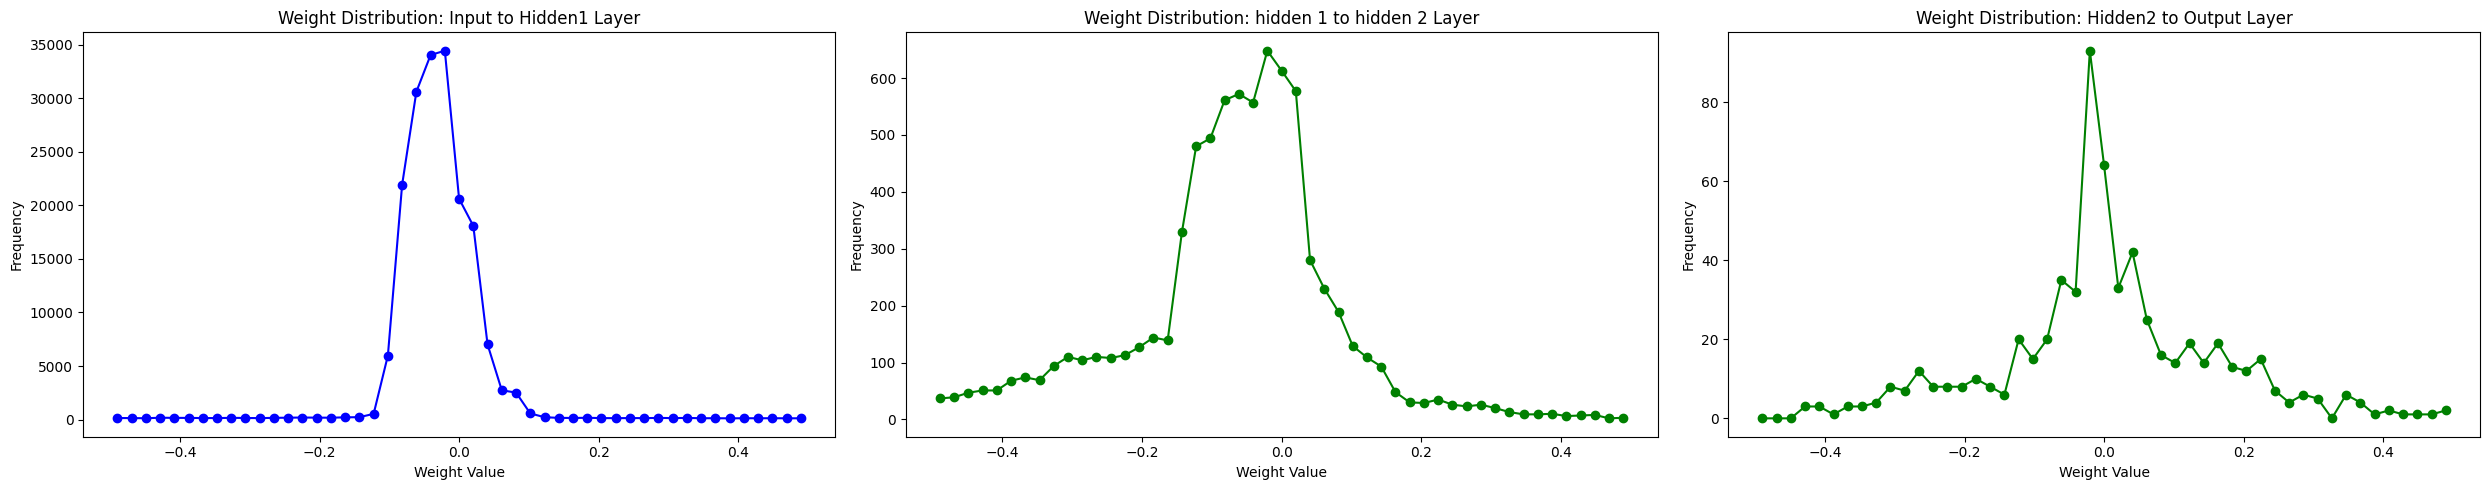

In [106]:
import matplotlib.pyplot as plt

fc_weights = model.fc.weight.cpu().detach().numpy().flatten()
fc2_weights = model.fc2.weight.cpu().detach().numpy().flatten()
out_weights = model.out.weight.cpu().detach().numpy().flatten()

bins = np.linspace(-0.5, 0.5, 50) 
fc_hist, fc_bins = np.histogram(fc_weights, bins=bins)
fc2_hist, fc2_bins = np.histogram(fc2_weights, bins=bins)
out_hist, out_bins = np.histogram(out_weights, bins=bins)

fc_bin_centers = 0.5 * (fc_bins[:-1] + fc_bins[1:])
fc2_bin_centers = 0.5 * (fc2_bins[:-1] + fc2_bins[1:])
out_bin_centers = 0.5 * (out_bins[:-1] + out_bins[1:])

plt.figure(figsize=(25, 5))

plt.subplot(1, 3, 1)
plt.plot(fc_bin_centers, fc_hist, marker='o', linestyle='-', color='b')
plt.title('Weight Distribution: Input to Hidden1 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 2)
plt.plot(fc2_bin_centers, fc2_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: hidden 1 to hidden 2 Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.subplot(1, 3, 3)
plt.plot(out_bin_centers, out_hist, marker='o', linestyle='-', color='g')
plt.title('Weight Distribution: Hidden2 to Output Layer')
plt.xlabel('Weight Value')
plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


In [107]:
import torch

def count_nonzero_weights_above_threshold(layer, threshold=0.01):
    return torch.sum(torch.abs(layer.weight) > threshold).item()

threshold_value = 0.01 

nonzero_fc1 = count_nonzero_weights_above_threshold(model.fc, threshold=threshold_value)
nonzero_fc2 = count_nonzero_weights_above_threshold(model.fc2, threshold=threshold_value)
nonzero_fc3 = count_nonzero_weights_above_threshold(model.out, threshold=threshold_value)

print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc1}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 1: {nonzero_fc2}')
print(f'Number of non-zero weights greater than {threshold_value} in layer 3: {nonzero_fc3}')

Number of non-zero weights greater than 0.01 in layer 1: 180577
Number of non-zero weights greater than 0.01 in layer 1: 7601
Number of non-zero weights greater than 0.01 in layer 3: 577


In [108]:
for i in range(len(lay)):
    if i > 0 and i <= len(lay)-1:
        norms = []
        for j in range(lay[i-1][1].weight.shape[0]):
            norms.append(np.sqrt(torch.sum(torch.square(lay[i][1].weight.data[:,j])).item())/np.sqrt(torch.sum(torch.square(lay[i-1][1].weight.data[j])).item()))
        print(norms)
        norms = torch.tensor(norms)
        print(norms.shape)

[0.4931485826337711, 0.5416846572624655, 0.5416929789541237, 0.22427292850272945, 0.5704953334272802, 0.5014946958403835, 0.5283054684333758, 0.48936311867086296, 0.5951697121371028, 0.6089212977157126, 0.5207482140436136, 0.2042955305532444, 0.5797647366350184, 0.6144767951720848, 0.5444626699691305, 0.5915456385811135, 0.4543864516962511, 0.47897748131251644, 0.5371236129400909, 0.5514945343024196, 0.528176793196303, 0.20253288401646544, 0.48616798598141875, 0.5786914709495244, 0.5295517280060598, 0.5556876740419858, 0.20108460107036938, 0.48412858509969764, 0.6224705868924248, 0.49944557063937284, 0.6105229168648186, 0.4864109978183542, 0.5530836253241849, 0.5350938566930903, 0.46215177848603756, 0.5111210446243947, 0.502673365629855, 0.5179815203565347, 0.5740401675637891, 0.5044985786327226, 0.519841552157167, 0.5905872625216934, 0.20601113775162974, 0.503992873712172, 0.5789401871602707, 0.6145122929494544, 0.45371676770548636, 0.4904081342957884, 0.49486027934529087, 0.605753807

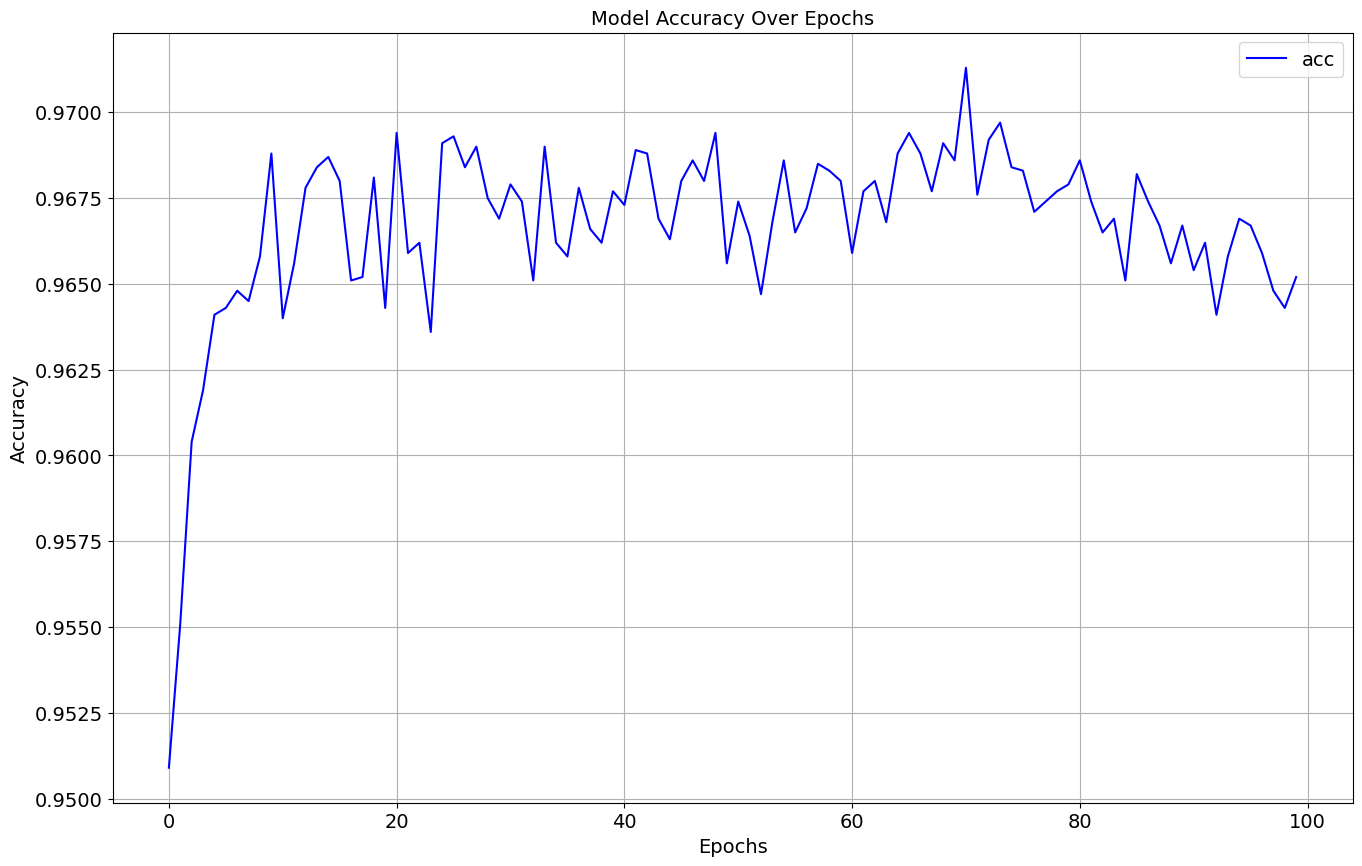

In [109]:
epochs_plot = list(range(100))

plt.figure(figsize=(16, 10))
plt.plot(epochs_plot, acc, linestyle='-', color='b', label='acc')

plt.xlabel('Epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.title('Model Accuracy Over Epochs', fontsize=14)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.grid(True)

plt.legend(fontsize=14)

plt.show()

In [110]:
import pickle
with open('cleanAcc4.pkl', 'wb') as f:
    pickle.dump(acc, f)

torch.save(model.state_dict(), 'cleanAccModel4.pt')